# **Import Libraries**

In [24]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import BernoulliRBM
from sklearn.utils import resample, shuffle


# **Load Dataset and Build Train Feature and Train Label Dataframes**

In [4]:
# Load Data

data_path = '/content/drive/My Drive/Aircraft_Accidents_New/'

main_df = pd.read_excel(os.path.join(data_path, 'AviationData.xlsx'))
main_df.head(3)

,Event Id,Type,Accident #,Event Date,Location,Country,Latitude,Longitude,Airport Code,Airport Name,Injury Severity,Aircraft Damage,Aircraft Category,Registration Number,Make,Model,Amateur Built,Number of Engines,Engine Type,FAR Description,Schedule,Purpose of Flight,Air Carrier,Total Fatal Injuries,Total Serious Injuries,Total Minor Injuries,Total Uninjured,Weather Condition,Broad Phase of Flight,Report Status,Publication Date
0,20180410X65647,Accident,GAA18CA206,04/10/2018,"Edgewood, NM",United States,35.0947,-106.164,1N1,SANDIA AIRPARK ESTATES EAST,Non-Fatal,Substantial,Airplane,N1685,BICE DAVID E,BEARHAWK,Yes,1,,Part 91: General Aviation,,Personal,,,,,1,VMC,,Preliminary,04/10/2018
1,20180410X72014,Accident,GAA18CA209,04/09/2018,"Lake Tahoe, CA",United States,38.8939,-119.995,TVL,LAKE TAHOE,Non-Fatal,Substantial,Airplane,N1832,CESSNA ECTOR,305A,No,1,,Part 91: General Aviation,,Instructional,,,,,1,VMC,,Preliminary,04/10/2018
2,20180406X70836,Accident,GAA18CA203,04/06/2018,"Caldwell, ID",United States,43.6419,-116.636,EUL,CALDWELL INDUSTRIAL,Non-Fatal,Substantial,Airplane,N66PB,CARR B L,RV 4,Yes,1,,Part 91: General Aviation,,Personal,,,,,2,VMC,,Preliminary,04/10/2018


In [5]:
# DROP UNWANTED COLUMNS FROM DATAFRAME

main_df = main_df.drop(columns=['Event Id','Accident #', 'Event Date', 'Location', 'Latitude', 'Longitude', 'Airport Code', 'Airport Name',
                                'Registration Number', 'Make', 'Model', 'FAR Description', 'Schedule', 'Air Carrier', 'Report Status', 'Publication Date'])

main_df.head(3)

,Type,Country,Injury Severity,Aircraft Damage,Aircraft Category,Amateur Built,Number of Engines,Engine Type,Purpose of Flight,Total Fatal Injuries,Total Serious Injuries,Total Minor Injuries,Total Uninjured,Weather Condition,Broad Phase of Flight
0,Accident,United States,Non-Fatal,Substantial,Airplane,Yes,1,,Personal,,,,1,VMC,
1,Accident,United States,Non-Fatal,Substantial,Airplane,No,1,,Instructional,,,,1,VMC,
2,Accident,United States,Non-Fatal,Substantial,Airplane,Yes,1,,Personal,,,,2,VMC,


In [6]:
# Make dataframes for Model Training Features and Model Training Labels

TrainFeatList = ['Country','Injury Severity', 'Aircraft Damage', 'Amateur Built', 'Aircraft Category', 'Total Uninjured', 
                 'Engine Type', 'Purpose of Flight', 'Weather Condition', 'Number of Engines', 'Broad Phase of Flight']

TargetFeatList = ['Type', 'Injury Severity', 'Aircraft Damage', 'Amateur Built', 'Weather Condition', 'Number of Engines', 
                  'Total Fatal Injuries', 'Total Serious Injuries', 'Total Minor Injuries'] 

df_training = main_df[TrainFeatList]
df_forLabels = main_df[TargetFeatList]

In [7]:
df_training.head(3)

,Country,Injury Severity,Aircraft Damage,Amateur Built,Aircraft Category,Total Uninjured,Engine Type,Purpose of Flight,Weather Condition,Number of Engines,Broad Phase of Flight
0,United States,Non-Fatal,Substantial,Yes,Airplane,1,,Personal,VMC,1,
1,United States,Non-Fatal,Substantial,No,Airplane,1,,Instructional,VMC,1,
2,United States,Non-Fatal,Substantial,Yes,Airplane,2,,Personal,VMC,1,


In [8]:
df_forLabels.head(3)

,Type,Injury Severity,Aircraft Damage,Amateur Built,Weather Condition,Number of Engines,Total Fatal Injuries,Total Serious Injuries,Total Minor Injuries
0,Accident,Non-Fatal,Substantial,Yes,VMC,1,,,
1,Accident,Non-Fatal,Substantial,No,VMC,1,,,
2,Accident,Non-Fatal,Substantial,Yes,VMC,1,,,


# **Create a New Target Label- ASI**

In [9]:
# REPLACE CATEGORIES WITH NUMERIC or NULL VALUES
label_df = df_forLabels.copy()

label_df['Type'].replace([' Accident ', ' Incident '] , [10, 1], inplace=True)
label_df['Injury Severity'].replace([' Fatal ', ' Non-Fatal '] ,[10, 1],  inplace=True)
label_df["Aircraft Damage"].replace([' Destroyed ', ' Substantial ', ' Minor '] , [10, 6, 2], inplace=True)
label_df['Amateur Built'].replace([' Yes ', ' No '] ,[10, 1], inplace=True)
label_df['Number of Engines'].replace( [0, 1, 2, 3, 4] , [10, 8, 5, 3, 1] , inplace=True)
label_df['Weather Condition'].replace([' UNK ', ' VMC ', ' IMC '], [5, 7, 9], inplace=True)
label_df.replace( r'^\s*$', 0, regex=True,  inplace=True)

label_df.head(3)

,Type,Injury Severity,Aircraft Damage,Amateur Built,Weather Condition,Number of Engines,Total Fatal Injuries,Total Serious Injuries,Total Minor Injuries
0,10,1,6,10,7,8,0,0,0
1,10,1,6,1,7,8,0,0,0
2,10,1,6,10,7,8,0,0,0


## **Dimensionality Reduction Using RBM Neural Network to create New Target Label - ASI**

In [29]:
scaler = MinMaxScaler().fit_transform(label_df)

rbm_target = BernoulliRBM(n_components= 10, n_iter=100).fit_transform(scaler)

rbm_target = pd.DataFrame(rbm_target)
rbm_target.head()


,0,1,2,3,4,5,6,7,8,9
0,0.001129,0.004748,0.011544,0.007713,0.999432,0.004920,0.999824,0.001660,0.000031,0.016141
1,0.001127,0.004711,0.011537,0.007631,0.999568,0.004881,0.999749,0.001654,0.000021,0.016188
2,0.001129,0.004748,0.011544,0.007713,0.999432,0.004920,0.999824,0.001660,0.000031,0.016141
3,0.000873,0.003798,0.011218,0.006156,0.999485,0.003937,0.999792,0.001323,0.000016,0.016048
4,0.000873,0.003798,0.011218,0.006156,0.999485,0.003937,0.999792,0.001323,0.000016,0.016048


In [30]:
pca = PCA(n_components= 1).fit_transform(rbm_target)
pca_tar = pd.DataFrame(pca)
pca_tar.head()

,0
0,-0.191764
1,-0.191783
2,-0.191764
3,-0.191619
4,-0.191619


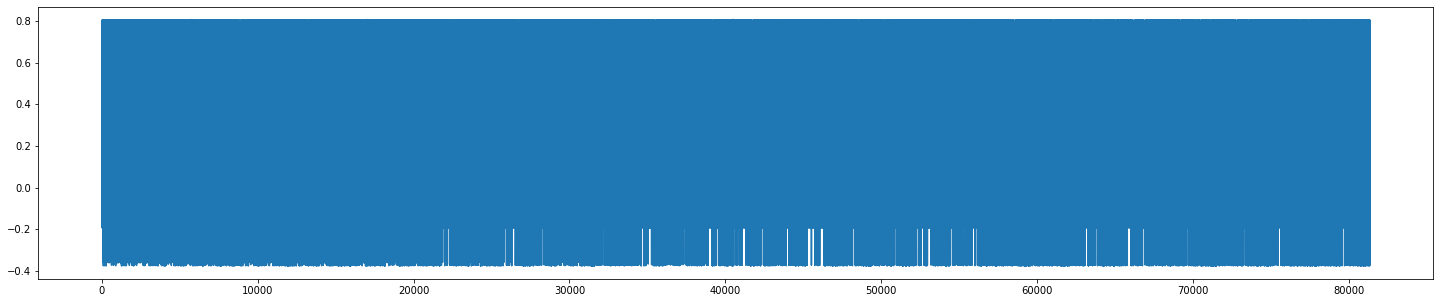

In [31]:
fig = plt.figure(figsize=(25,5))
plt.plot(pca_tar)
plt.show()

In [33]:
# COMPUTE MEANS TO SPLIT TARGET FEATURE VALUES INTO 4 CATEGORIES
labels = pca_tar.copy()

mean2 = float(labels.mean())

df_top_two_classes = labels[labels>= mean2]
mean1 = float(df_top_two_classes.mean())

df_bottom_two_classes = labels[labels < mean2]
mean3 = float(df_bottom_two_classes.mean())

print ('mean1', mean1)
print('mean2', mean2)
print ('mean3', mean3)

mean1 0.8023028154270029
mean2 1.0021229067750926e-13
mean3 -0.20085002176139177


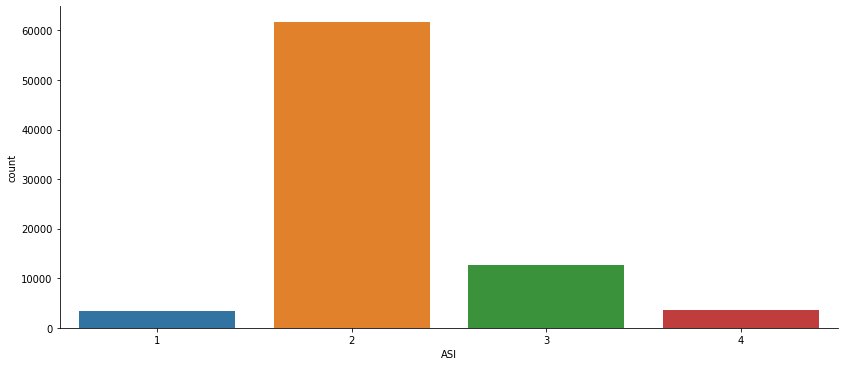

In [34]:
# NAME THE CATEGORIES CREATED 
targets = pd.DataFrame(index=labels.index, columns=["ASI"])

for i in range(len(labels)) :
    
    if (labels.iloc[i] >= mean1).bool() :
        targets.iloc[i] = 4             # 4 - Catastrophic
        
    elif (labels.iloc[i] < mean1).bool() and (labels.iloc[i] >= mean2).bool() :
        targets.iloc[i] = 3             # 3 - Hazardous
        
    elif (labels.iloc[i] < mean2).bool() and (labels.iloc[i] >= mean3).bool() :
        targets.iloc[i] = 2             # 2 - Minor
        
    else :
        targets.iloc[i] = 1             # 1 - Negligible

sns.catplot(x='ASI', data=targets, kind='count', height=5, aspect= 2.33)       

# **Data Preprocessing to Training Features Dataframe**

In [35]:
Tr_df = df_training.copy()

Tr_df.replace(r'^\s*$' , 0, regex=True, inplace=True)
Tr_df.fillna(0)

for i in range(df_training.shape[1]):
    Tr_df[TrainFeatList[i]] = Tr_df[TrainFeatList[i]].astype(str)

Tr_df.head(2)

,Country,Injury Severity,Aircraft Damage,Amateur Built,Aircraft Category,Total Uninjured,Engine Type,Purpose of Flight,Weather Condition,Number of Engines,Broad Phase of Flight
0,United States,Non-Fatal,Substantial,Yes,Airplane,1,0,Personal,VMC,1,0
1,United States,Non-Fatal,Substantial,No,Airplane,1,0,Instructional,VMC,1,0


# **Apply Label Encoding**

In [36]:
labEnc = Tr_df.apply(LabelEncoder().fit_transform)
labEnc.head(3)

,Country,Injury Severity,Aircraft Damage,Amateur Built,Aircraft Category,Total Uninjured,Engine Type,Purpose of Flight,Weather Condition,Number of Engines,Broad Phase of Flight
0,167,1,2,1,0,1,13,14,2,1,12
1,167,1,2,0,0,1,13,12,2,1,12
2,167,1,2,1,0,112,13,14,2,1,12


In [37]:
# Create the final Dataframe 

df_final = pd.merge(labEnc, targets, left_index=True, right_index=True)
df_final.head()

,Country,Injury Severity,Aircraft Damage,Amateur Built,Aircraft Category,Total Uninjured,Engine Type,Purpose of Flight,Weather Condition,Number of Engines,Broad Phase of Flight,ASI
0,167,1,2,1,0,1,13,14,2,1,12,2
1,167,1,2,0,0,1,13,12,2,1,12,2
2,167,1,2,1,0,112,13,14,2,1,12,2
3,167,1,2,0,0,1,13,14,3,1,12,2
4,167,1,2,0,0,112,13,12,3,1,12,2


# **Perform Resampling to Solve the Class Imbalance Issue**

In [38]:
class_names = {1: 'Negligible', 2: 'Minor', 3: 'Hazard', 4: 'Catastrophe'}

# GET THE TOTAL SAMPLE COUNT

print(class_names[1], ' : ', (df_final["ASI"]==1).sum())
print(class_names[2], ' : ', (df_final["ASI"]==2).sum())
print(class_names[3], ' : ', (df_final["ASI"]==3).sum())
print(class_names[4], ' : ', (df_final["ASI"]==4).sum())


Negligible  :  3312
Minor  :  61763
Hazard  :  12674
Catastrophe  :  3617


In [39]:
# PERFORM RESAMPLING OF DATASET

df1 = df_final.copy()

class1 = df1[df1.ASI==1]
class2 = df1[df1.ASI==2]
class3 = df1[df1.ASI==3]
class4 = df1[df1.ASI==4]

class1 = resample(class1, replace=True, n_samples=10000, random_state=42)          # UPSAMPLE CLASS 1 

class2 = resample(class2, replace=False, n_samples=10000, random_state=42)           # DOWNSAMPLE CLASS 2

class3 = resample(class3, replace=False, n_samples=10000, random_state=42)           # DOWNSAMPLE CLASS 3

class4 = resample(class4, replace=True, n_samples=10000, random_state=42)           # UPSAMPLE CLASS 4

rs_df = pd.concat([class1, class2, class3, class4])

rs_df = shuffle(rs_df)

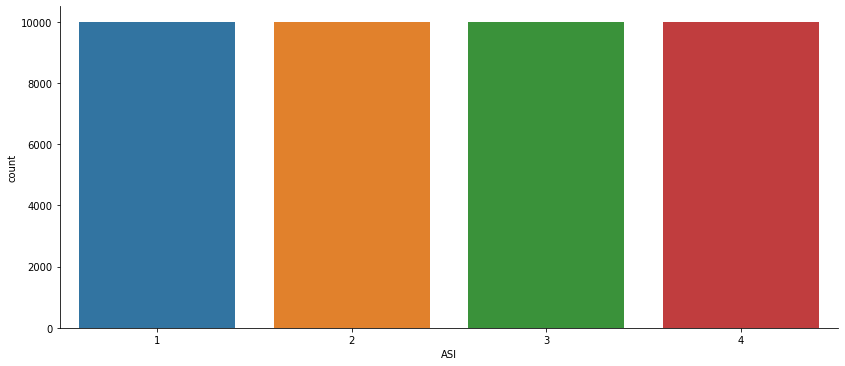

In [40]:
# PLOT OF CLASS COUNTS

sns.catplot(x='ASI', data=rs_df, kind='count', height=5, aspect= 2.33)       

# **Export the balanced dataset as csv file**

In [41]:
rs_df.to_csv(os.path.join(data_path, "preprocessed_by_RBM.csv"))                   # Save as a CSV File
